In [1]:
import itertools
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import pyproj
import numpy as np
from dask.distributed import Client
import verde as vd
from vector3d import Vector3D, vector3d_jacobian
from vector3d.utils import plot_data, combinations, sample_from_grid

In [2]:
data = vd.datasets.fetch_california_gps().rename(columns=dict(
    velocity_east='east_velocity', velocity_north='north_velocity', velocity_up='up_velocity'))
region = vd.get_region((data.longitude, data.latitude))
# Convert from m/yr to mm/yr
for comp in ['east_velocity', 'north_velocity', 'up_velocity']:
    data[comp] = 1e3*data[comp]
proj = pyproj.Proj(proj='merc', lat_ts=data.latitude.mean())

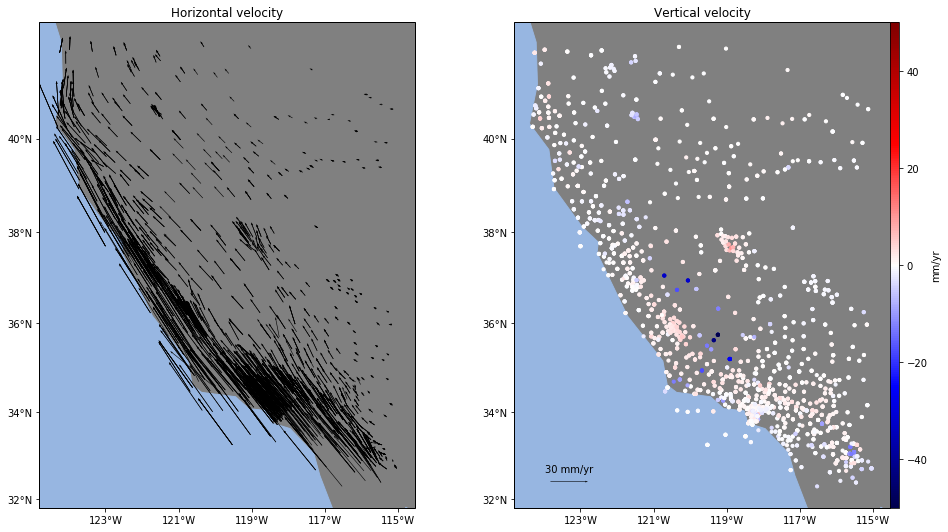

In [3]:
fig, ax = plot_data(data, maxabs=50, pad=0.5)

In [4]:
train, test = vd.train_test_split(proj(data.longitude.values, data.latitude.values), 
                                  (data.east_velocity, data.north_velocity, data.up_velocity),
                                  random_state=0)

In [5]:
spacing = 0.1

In [6]:
chain = vd.Chain([
    ('mean', vd.BlockReduce(np.mean, spacing=spacing*100e3)),
    ('trend', vd.VectorTrend(1)),
    ('spline', Vector3D(depth=10000, poisson=0.5, damping=1e1))
])
chain.fit(*train)
score = chain.score(*test)
print("R2 score:", score)

R2 score: 0.9396142319648476


In [13]:
grid = chain.grid(region=region, spacing=spacing, projection=proj,
                  dims=['latitude', 'longitude'], 
                  data_names=['east_velocity', 'north_velocity', 'up_velocity'])
mask = vd.distance_mask((data.longitude, data.latitude), maxdist=0.5, 
                        region=region, spacing=spacing)
grid = grid.where(mask)
grid

<xarray.Dataset>
Dimensions:         (latitude: 97, longitude: 94)
Coordinates:
  * longitude       (longitude) float64 235.7 235.8 235.9 236.0 236.1 236.2 ...
  * latitude        (latitude) float64 32.29 32.39 32.49 32.59 32.69 32.79 ...
Data variables:
    east_velocity   (latitude, longitude) float64 nan nan nan nan nan nan ...
    north_velocity  (latitude, longitude) float64 nan nan nan nan nan nan ...
    up_velocity     (latitude, longitude) float64 nan nan nan nan nan nan ...
Attributes:
    metadata:  Generated by Chain(steps=[('mean', BlockReduce(adjust='spacing...

/home/leo/miniconda3/envs/aogs2018-gps/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1744: RuntimeWarning: invalid value encountered in less
  u, v = self.projection.transform_vectors(t, x, y, u, v)
/home/leo/miniconda3/envs/aogs2018-gps/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1744: RuntimeWarning: invalid value encountered in greater
  u, v = self.projection.transform_vectors(t, x, y, u, v)


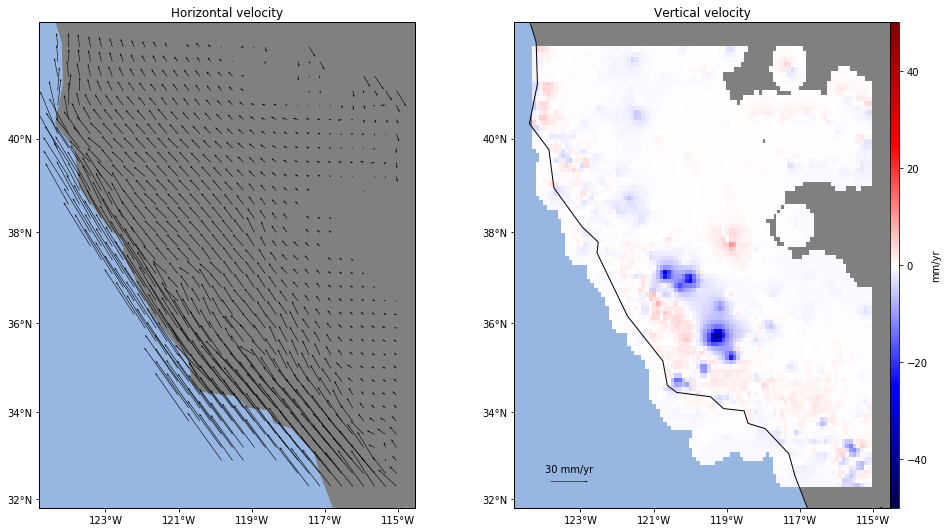

In [14]:
fig, axes = plot_data(grid, every=3, maxabs=50, pad=0.5)

In [15]:
def make_residuals(gridder):
    predicted = gridder.predict(proj(data.longitude.values, data.latitude.values))
    res = data.copy()    
    names = ['east_velocity', 'north_velocity', 'up_velocity']
    for pred, name in zip(predicted, names):
        res[name] = data[name] - pred
    return res

In [10]:
residuals = make_residuals(chain)

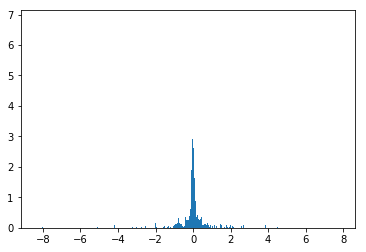

In [11]:
_ = plt.hist(residuals.up_velocity, bins='auto', density=True)

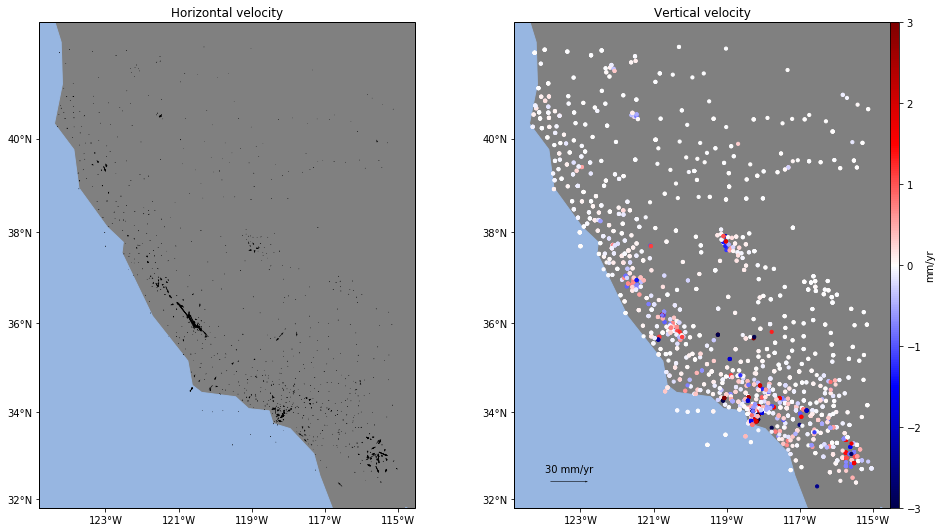

In [12]:
_ = plot_data(residuals, pad=0.5)